First we will use the [example from scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), then we will redo this example using Jacobian regularization

[-1.60931179]
[  0.46754142 -17.78954475  23.5926603   -7.26289872]
[-2.98294669e+03  1.03899932e+05 -1.87417069e+06  2.03717225e+07
 -1.44873987e+08  7.09318780e+08 -2.47066977e+09  6.24564048e+09
 -1.15677067e+10  1.56895696e+10 -1.54006776e+10  1.06457788e+10
 -4.91379977e+09  1.35920330e+09 -1.70381654e+08]


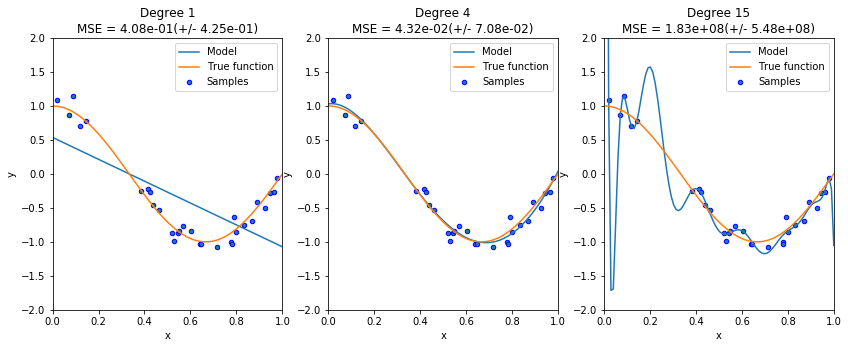

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    print(pipeline.steps[1][1].coef_)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

We see that for higher polynomial degrees we have a lot of overfitting. This is because Ridge regularization pushes all coefficients lower with the same force, whereas what we really want to accomplish is to make the function smoother, which means lowering the higher degree coefficients more, than the lower degree coefficients.

In [4]:
import tensorflow as tf

Epoch 0 Cost = 0.29400635
Epoch 5 Cost = 0.3490091
Epoch 10 Cost = 0.17574118
Epoch 15 Cost = 0.13921247
Epoch 20 Cost = 0.12877807
Epoch 25 Cost = 0.120922014
Epoch 30 Cost = 0.11476391
Epoch 35 Cost = 0.11310854
Epoch 40 Cost = 0.11485051
Epoch 45 Cost = 0.11640746
Epoch 50 Cost = 0.115790226
[ 0.53004116 -1.5159643 ]
Epoch 0 Cost = 0.29400635
Epoch 15 Cost = 0.116327636
Epoch 30 Cost = 0.03801206
Epoch 45 Cost = 0.012073817
Epoch 60 Cost = 0.006918408
Epoch 75 Cost = 0.0068107876
Epoch 90 Cost = 0.006818063
Epoch 105 Cost = 0.0067673824
Epoch 120 Cost = 0.006758134
Epoch 135 Cost = 0.0067577977
Epoch 150 Cost = 0.006756949
[ 1.2515295 -3.6530073 -1.6541114  1.0222219  3.1699235]
Epoch 0 Cost = 0.29400635
Epoch 3391 Cost = 0.0054246513
Epoch 6782 Cost = 0.005355025
Epoch 10173 Cost = 0.0053507257
Epoch 13564 Cost = 0.0062777936
Epoch 16955 Cost = 0.0053495807
Epoch 20346 Cost = 0.0053492244
Epoch 23737 Cost = 0.005348903
Epoch 27128 Cost = 0.005348648
Epoch 30519 Cost = 0.0053531188


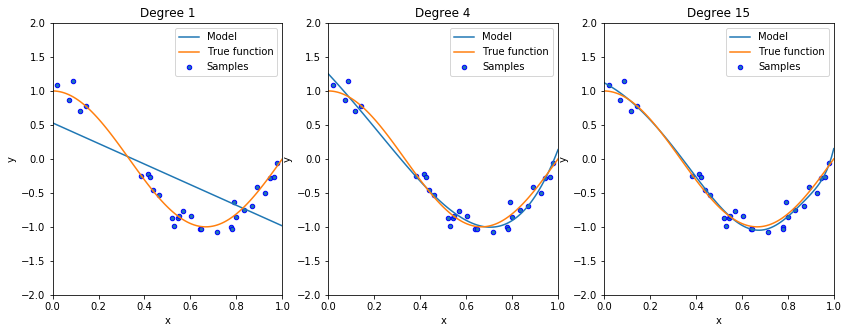

In [45]:
learning_rates = [1.0, 0.3, 0.2]
lmbda = 0.0
n_epochs = [51, 151, 33910]

plt.figure(figsize=(14, 5))
for i, degree in enumerate(degrees):
    
    ax = plt.subplot(1, len(degrees), i + 1)

    X_test = np.linspace(0, 1, 100)
    
    #Defining polynomial features, using scaler
    x_train = PolynomialFeatures(degree=degree).fit_transform(X.reshape(-1, 1))
    x_test = PolynomialFeatures(degree=degree).fit_transform(X_test.reshape(-1, 1))
    
    #Defining the placeholders and variables
    input_x = tf.placeholder(dtype='float', shape=(None,degree+1))
    input_y = tf.placeholder(dtype='float', shape=(None,1))   
    coef = tf.Variable(initial_value=np.zeros((degree+1,1)), name="coef", dtype='float')
    
    prediction = input_x @ coef
    loss = (input_y - prediction) ** 2 / 2
    cost = tf.reduce_mean(loss)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rates[i])
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rates[i])
    
    training_op = optimizer.minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs[i]):
            if epoch % (n_epochs[i] // 10) == 0:
                print("Epoch", epoch, "Cost =", cost.eval(feed_dict={input_x: x_train, input_y: y.reshape(-1,1) }))
            sess.run(training_op, feed_dict={input_x: x_train, input_y: y.reshape(-1,1) })
        
        y_plot = prediction.eval(feed_dict={input_x: x_test})
        print(coef.eval().reshape(-1))
        
    plt.plot(X_test, y_plot, label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}".format(degree))



plt.show()
